In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preprocessing

In [2]:
# load the data
bike_share_hour_df = pd.read_csv('/Users/brianmiller/Desktop/ebike_usage_regression/bike_share_hour.csv')


### Data Preparation

In [3]:
## Look at the dataset, and convert the columns that are categorical to a pandas “category” type ##
bike_share_hour_df['dteday'] = bike_share_hour_df['dteday'].astype('category')
bike_share_hour_df['season'] = bike_share_hour_df['season'].astype('category')
bike_share_hour_df['yr'] = bike_share_hour_df['yr'].astype('category')
bike_share_hour_df['mnth'] = bike_share_hour_df['mnth'].astype('category')
bike_share_hour_df['hr'] = bike_share_hour_df['hr'].astype('category')
bike_share_hour_df['holiday'] = bike_share_hour_df['holiday'].astype('category')
bike_share_hour_df['weekday'] = bike_share_hour_df['weekday'].astype('category')
bike_share_hour_df['workingday'] = bike_share_hour_df['workingday'].astype('category')
bike_share_hour_df['weathersit'] = bike_share_hour_df['weathersit'].astype('category')

print(bike_share_hour_df.info())
print("\n")
print(bike_share_hour_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     17379 non-null  int64   
 1   dteday      17379 non-null  category
 2   season      17379 non-null  category
 3   yr          17379 non-null  category
 4   mnth        17379 non-null  category
 5   hr          17379 non-null  category
 6   holiday     17379 non-null  category
 7   weekday     17379 non-null  category
 8   workingday  17379 non-null  category
 9   weathersit  17379 non-null  category
 10  temp        17379 non-null  float64 
 11  atemp       17379 non-null  float64 
 12  hum         17379 non-null  float64 
 13  windspeed   17379 non-null  float64 
 14  casual      17379 non-null  int64   
 15  registered  17379 non-null  int64   
 16  cnt         17379 non-null  int64   
dtypes: category(9), float64(4), int64(4)
memory usage: 1.3 MB
None


   instant      dteday 

In [4]:
## Look for non-null values in the dataset ##
print(bike_share_hour_df.isna().sum())

print("\n There were no missing values")

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

 There were no missing values


In [5]:
# drop variables that are not useful
bike_share_hour_df.drop(["casual", "registered", "dteday", "instant", "atemp"], inplace=True, axis=1)

# explanation of variables dropped:
# casual and registered: These variables are dependant on the outcome variable, so they are not that useful. They are.. of the riders
# counted, how many are registered uses, and how many are not.
#
# dteday: the day of the month, while this could be useful from a time series approach, it's not that useful for my regression approach.
# There are only 2 years worth of data, with season and month columns to give us the aproximate time of year.
#
# instant: this is just integers 1-nrow, essentially it's just a copy of the index
#
# atemp: is the same variable as temp (> 0.9 R^2)

### Exploratory Data Analysis  
### And Visualizations

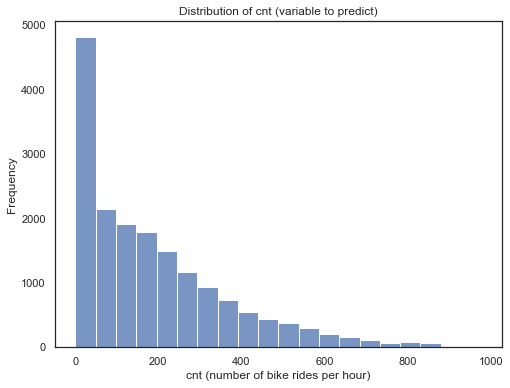

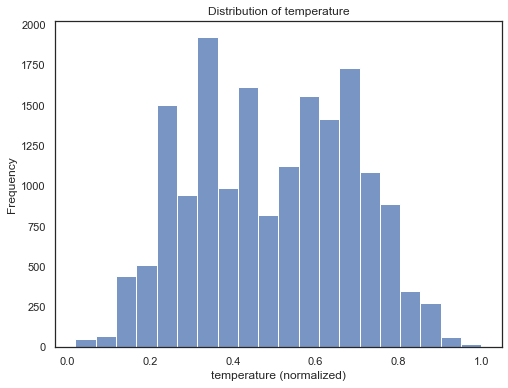

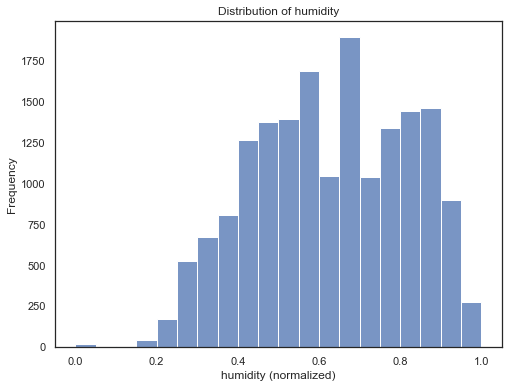

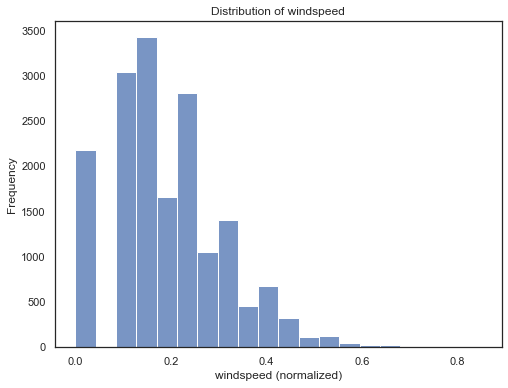

In [6]:
# Set the Seaborn style to 'white' for a clean background
sns.set(style="white")

# Histogram for 'cnt'
plt.figure(figsize=(8, 6))
sns.histplot(bike_share_hour_df['cnt'], bins=20, palette="muted", kde=False)
plt.xlabel('cnt (number of bike rides per hour)')
plt.ylabel('Frequency')
plt.title('Distribution of cnt (variable to predict)')
plt.show()

# Histogram for 'temp'
plt.figure(figsize=(8, 6))
sns.histplot(bike_share_hour_df['temp'], bins=20, palette="muted", kde=False)
plt.xlabel('temperature (normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of temperature')
plt.show()

# Histogram for 'hum'
plt.figure(figsize=(8, 6))
sns.histplot(bike_share_hour_df['hum'], bins=20, palette="muted", kde=False)
plt.xlabel('humidity (normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of humidity')
plt.show()

# Histogram for 'windspeed'
plt.figure(figsize=(8, 6))
sns.histplot(bike_share_hour_df['windspeed'], bins=20, palette="muted", kde=False)
plt.xlabel('windspeed (normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of windspeed')
plt.show()


R^2 score for Scatter Plot: hum vs cnt: 0.10427134653986614


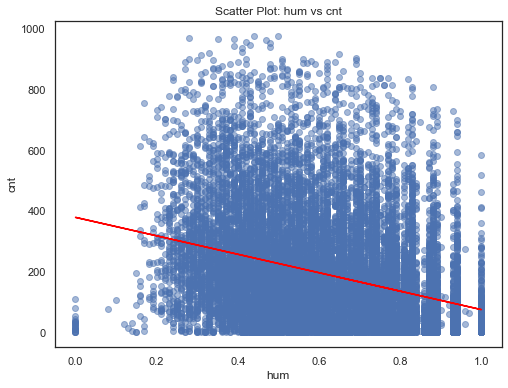

R^2 score for Scatter Plot: temp vs cnt: 0.16384059523903427


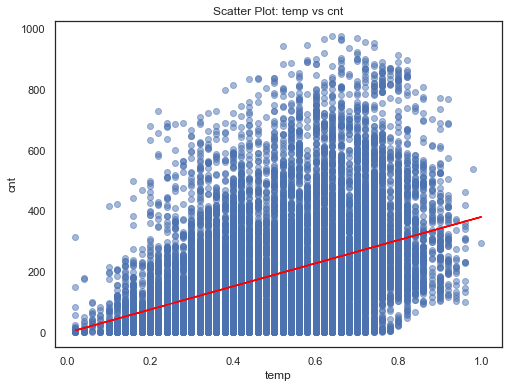

R^2 score for Scatter Plot: windspeed vs cnt: 0.008692538465183253


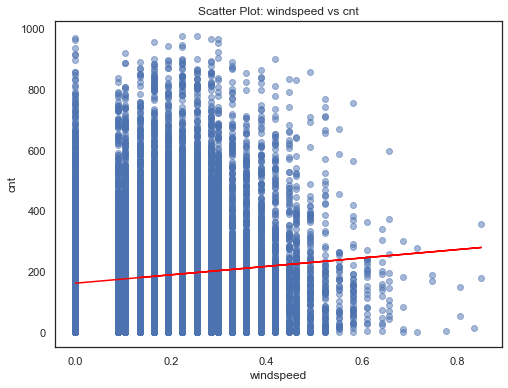

In [7]:
from sklearn.metrics import r2_score

# Define a function to create scatter plot, add trendline and print R^2 score
def plot_with_trendline(x, y, xlabel, ylabel, title):
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add trendline
    coefficients = np.polyfit(x, y, 1)
    poly = np.poly1d(coefficients)
    plt.plot(x, poly(x), color='red')

    # Calculate and print R^2 score
    y_pred = poly(x)
    r2 = r2_score(y, y_pred)
    print(f'R^2 score for {title}: {r2}')

    plt.show()

# Call the function for 'hum', 'temp', 'windspeed'
plot_with_trendline(bike_share_hour_df['hum'], bike_share_hour_df['cnt'], 'hum', 'cnt', 'Scatter Plot: hum vs cnt')
plot_with_trendline(bike_share_hour_df['temp'], bike_share_hour_df['cnt'], 'temp', 'cnt', 'Scatter Plot: temp vs cnt')
plot_with_trendline(bike_share_hour_df['windspeed'], bike_share_hour_df['cnt'], 'windspeed', 'cnt', 'Scatter Plot: windspeed vs cnt')


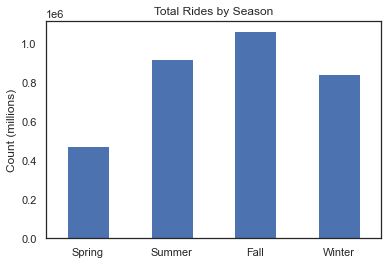

In [8]:
# Total Rides by Season

# group the dataframe 
season_cnt = bike_share_hour_df.groupby('season')['cnt'].sum()

# create a bar plot
ax = season_cnt.plot(kind='bar')

# set the x-axis tick labels 
ax.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'], rotation=0)

# set the axis labels and title
plt.xlabel('')
plt.ylabel('Count (millions)')
plt.title('Total Rides by Season')

# display the plot
plt.show()


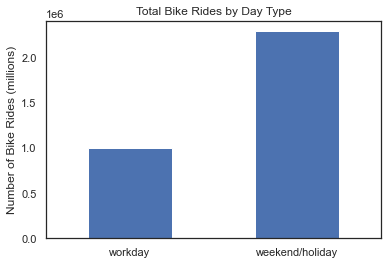

Number of bike rides total for all Weekends or holidays: 2,292,410 
Number of bike rides total for all working days: 1,000,269


In [9]:
# Total Bike Rides by Day

# group the dataframe 
working_cnt = bike_share_hour_df.groupby('workingday')['cnt'].sum()

# create a bar plot
ax = working_cnt.plot(kind='bar')

# set the x-axis tick labels 
ax.set_xticklabels(['workday', 'weekend/holiday'], rotation=0)

# set the axis labels and title
plt.xlabel('')
plt.ylabel('Number of Bike Rides (millions)')
plt.title('Total Bike Rides by Day Type')

# display the plot
plt.show()

print("Number of bike rides total for all Weekends or holidays: 2,292,410 \nNumber of bike rides total for all working days: 1,000,269")

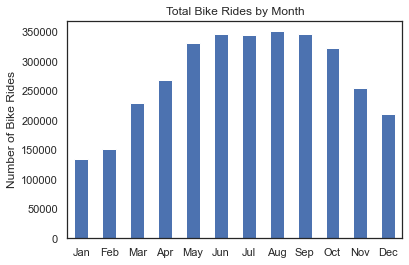

In [10]:
# Total Bike Rides by Month

# group the dataframe 
mnth_cnt = bike_share_hour_df.groupby('mnth')['cnt'].sum()

# create a bar plot
ax = mnth_cnt.plot(kind='bar')

# set the x-axis tick labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(months, rotation=0)

# set the axis labels and title
plt.xlabel('')
plt.ylabel('Number of Bike Rides')
plt.title('Total Bike Rides by Month')

# display the plot
plt.show()


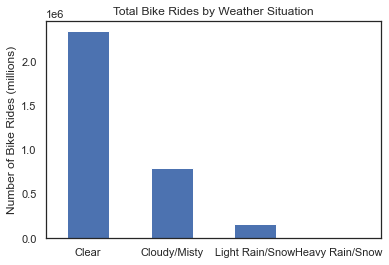

Explanation of Weather Situations
1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud
2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

weathersit
1    2338173
2     795952
3     158331
4        223
Name: cnt, dtype: int64

It looks like there were only 223 brave souls that decided to rent a bike when the weather was horrible (weather situation = 4)


In [11]:
# Total Bike Rides bt Weather Situation

# group the dataframe 
weather_cnt = bike_share_hour_df.groupby('weathersit')['cnt'].sum()

# create a bar plot
ax = weather_cnt.plot(kind='bar')

# set the x-axis tick labels
ax.set_xticklabels(["Clear","Cloudy/Misty","Light Rain/Snow","Heavy Rain/Snow"], rotation=0)

# set the axis labels and title
plt.xlabel('')
plt.ylabel('Number of Bike Rides (millions)')
plt.title('Total Bike Rides by Weather Situation')


# display the plot
plt.show()

print("Explanation of Weather Situations")
print('1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud')
print('2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
print('3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds')
print('4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog\n')
print(weather_cnt)
print("\nIt looks like there were only 223 brave souls that decided to rent a bike when the weather was horrible (weather situation = 4)")

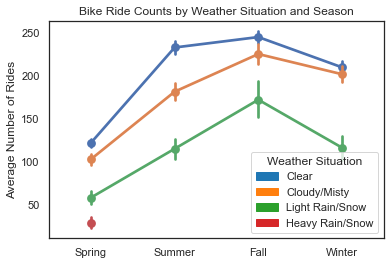

Season Explanation: 1=Spring 2=Summer 3=Fall 4=Winter

Explanation of Weather Situations
1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud
2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

As the weather gets worse there are less rides. From good biking weather (1) to ok weather (2) does not stop a lot of people. But riding in bad (3) or terrible (4) biking weather seems to really dissuade riders. 

NOTE:
There are only three datapoints for rides during the worst weather situation metric (4). 
The three cnt data points are 23, 36, 164 
The interesting 164 data point is what is causing the variance to be so large.


In [12]:
# Bike Ride Counts by Weather Situation and Season

sns.pointplot(x='season', y='cnt', hue='weathersit', data=bike_share_hour_df[~((bike_share_hour_df['weathersit'] == 4) & (bike_share_hour_df['cnt'] == 164))])
plt.xlabel('')
plt.ylabel('Average Number of Rides')
plt.title('Bike Ride Counts by Weather Situation and Season')

# Manually set the x labels
season_labels = ['Spring', 'Summer', 'Fall', 'Winter']
plt.xticks(range(4), season_labels)

import matplotlib.patches as mpatches

# Create custom legend handles with colored bullets
legend_handles = [
    mpatches.Patch(color='tab:blue', label='Clear'),
    mpatches.Patch(color='tab:orange', label='Cloudy/Misty'),
    mpatches.Patch(color='tab:green', label='Light Rain/Snow'),
    mpatches.Patch(color='tab:red', label='Heavy Rain/Snow')
]

plt.legend(title='Weather Situation', handles=legend_handles)

plt.show()

print("Season Explanation: 1=Spring 2=Summer 3=Fall 4=Winter\n")
print("Explanation of Weather Situations")
print('1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud')
print('2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
print('3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds')
print('4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog\n')
print("As the weather gets worse there are less rides. From good biking weather (1) to ok weather (2) does not stop a lot of people. But riding in bad (3) or terrible (4) biking weather seems to really dissuade riders. ")
print("\nNOTE:\nThere are only three datapoints for rides during the worst weather situation metric (4). \nThe three cnt data points are 23, 36, 164 \nThe interesting 164 data point is what is causing the variance to be so large.")


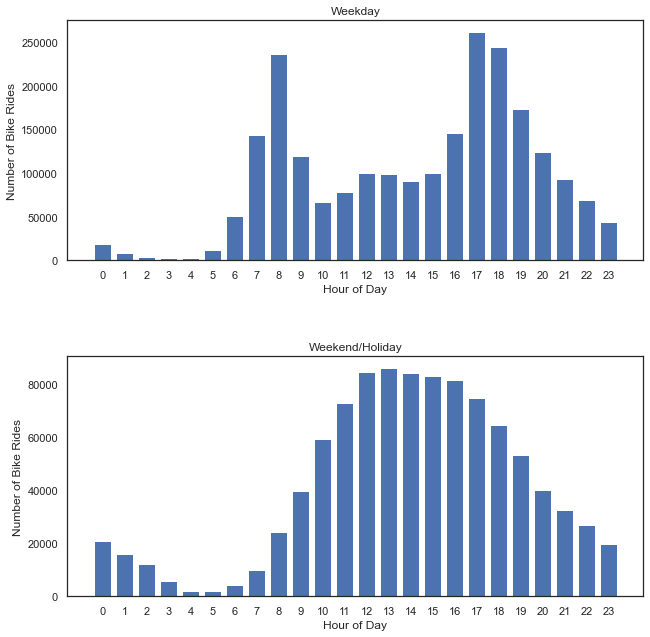

For the weekend and holiday days, we no longer see the 9-5 commuting trend. We see peak usage around 12pm-4pm, and usage tail off on either side of that window.


In [13]:
# Bike Ride Count by hour, and type of day

# group the dataframe by hour and workingday
hour_cnt_workingday = bike_share_hour_df.groupby(['hr', 'workingday'])['cnt'].sum()

# pivot the dataframe to create separate columns for workingday=1 and workingday=0
hour_cnt_workingday = hour_cnt_workingday.unstack(level=1)

# create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# create a bar plot for workingday=1 in the first subplot
axs[0].bar(hour_cnt_workingday.index, hour_cnt_workingday[1])
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Number of Bike Rides')
axs[0].set_title('Weekday')
axs[0].set_xticks(range(24))  # set x-axis ticks to integers 0-23

# create a bar plot for workingday=0 in the second subplot
axs[1].bar(hour_cnt_workingday.index, hour_cnt_workingday[0])
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Number of Bike Rides')
axs[1].set_title('Weekend/Holiday')
axs[1].set_xticks(range(24))  # set x-axis ticks to integers 0-23

# adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

# display the plots
plt.show()


print("For the weekend and holiday days, we no longer see the 9-5 commuting trend. We see peak usage around 12pm-4pm, and usage tail off on either side of that window.")


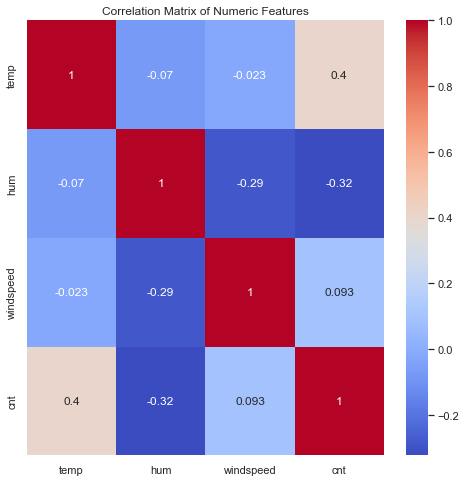


Correlations that were <= -0.25
hum  windspeed   -0.290105
     cnt         -0.322911
dtype: float64
It's interesting and cool to actually see humidity being negatively correlated with bike usage.


In [14]:
# correlation heatmap

# select only the numeric features
categorical_columns = bike_share_hour_df.select_dtypes(include=['category']).columns.tolist()
bike_share_hour_numeric_df = bike_share_hour_df.drop(categorical_columns, axis=1)

# create a correlation matrix
corr_matrix = bike_share_hour_numeric_df.corr()

fig, ax = plt.subplots(figsize=(8,8))  # create a figure and axis object
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)  # plot the correlation matrix using a heatmap
plt.title('Correlation Matrix of Numeric Features')
plt.show() # display the plot


# get the correlations with a metric greater than 0.8
pos_corr = corr_matrix[corr_matrix >= 0.8]
pos_corr = pos_corr.dropna(how='all').dropna(axis=1, how='all')  # drop the correlations of the variables with themselves
pos_correlations = pos_corr.unstack().sort_values(ascending=False).drop_duplicates()  # get the list of correlations

# get the correlations with a metric greater than 0.8
neg_corr = corr_matrix[(corr_matrix <= -0.25) & (corr_matrix != -1.0)]
neg_corr = neg_corr.dropna(how='all').dropna(axis=1, how='all')  # drop the correlations of the variables with themselves
neg_correlations = neg_corr.unstack().sort_values(ascending=False).drop_duplicates()  # get the list of correlations

# print the list of correlations
print("\nCorrelations that were <= -0.25")
print(neg_correlations[~neg_correlations.isna()])
print("It's interesting and cool to actually see humidity being negatively correlated with bike usage.")



### Data Splitting

#### Scale and Encode

In [15]:
# scale the numeric variables, one-hot encode the categorical variables

### scale the numeric features
scaler = StandardScaler()
bike_share_hour_numeric_scaled = scaler.fit_transform(bike_share_hour_numeric_df)
numeric_features_names = bike_share_hour_numeric_df.columns.to_list()

# create a new dataframe with the scaled features
bike_share_hour_numeric_scaled_df = pd.DataFrame(bike_share_hour_numeric_scaled, columns=numeric_features_names)


### one-hot encode the categorical variables
categorical_columns = bike_share_hour_df.select_dtypes(include=['category']).columns.tolist()

# use get_dummies to one-hot-encode categorical columns
one_hot_encoded = pd.get_dummies(bike_share_hour_df[categorical_columns], prefix=categorical_columns)

### combine the numeric and categorical variables
bike_share_hour_df_scaled_hot = pd.concat([bike_share_hour_numeric_scaled_df, one_hot_encoded], axis=1)

bike_share_hour_df_scaled_hot.head()

,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334648,0.947372,-1.553889,-0.956339,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,-1.438516,0.895539,-1.553889,-0.824022,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
2,-1.438516,0.895539,-1.553889,-0.868128,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
3,-1.334648,0.636370,-1.553889,-0.972879,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
4,-1.334648,0.636370,-1.553889,-1.039037,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0


In [16]:
bike_share_hour_df_scaled_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          17379 non-null  float64
 1   hum           17379 non-null  float64
 2   windspeed     17379 non-null  float64
 3   cnt           17379 non-null  float64
 4   season_1      17379 non-null  uint8  
 5   season_2      17379 non-null  uint8  
 6   season_3      17379 non-null  uint8  
 7   season_4      17379 non-null  uint8  
 8   yr_0          17379 non-null  uint8  
 9   yr_1          17379 non-null  uint8  
 10  mnth_1        17379 non-null  uint8  
 11  mnth_2        17379 non-null  uint8  
 12  mnth_3        17379 non-null  uint8  
 13  mnth_4        17379 non-null  uint8  
 14  mnth_5        17379 non-null  uint8  
 15  mnth_6        17379 non-null  uint8  
 16  mnth_7        17379 non-null  uint8  
 17  mnth_8        17379 non-null  uint8  
 18  mnth_9        17379 non-nu

#### Split

In [17]:
# split the data, 33%

# split the dataframe into features and target
predictors = bike_share_hour_df_scaled_hot.drop('cnt', axis=1)
target = bike_share_hour_df_scaled_hot['cnt']

# split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

# print the shapes of the training and testing sets
print('Training set shape:', x_train.shape, y_train.shape)
print('Testing set shape:', x_test.shape, y_test.shape)


Training set shape: (11643, 60) (11643,)
Testing set shape: (5736, 60) (5736,)


# Model Building and Evaluation

### Model Building

In [18]:
# linear regression

# instantiate a linear regression model
lm_model = LinearRegression()
lm_model.fit(x_train, y_train)

# make predictions
y_pred = lm_model.predict(x_train)

print("Training R^2: ", r2_score(y_train, y_pred))
print("Training MSE: ", mean_squared_error(y_train, y_pred))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

Training R^2:  0.6887766738198227
Training MSE:  0.3157866403340322
Training RMSE: 0.5619489659515642


In [19]:
# Decision Tree Regression

# Create a decision tree regressor and fit it to the training data
dt_regressor = DecisionTreeRegressor(random_state=0)
dt_regressor.fit(x_train, y_train)

# make predictions
y_pred_dt = dt_regressor.predict(x_train)

print("Training R^2: ", r2_score(y_train, y_pred_dt))
print("Training MSE: ", mean_squared_error(y_train, y_pred_dt))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_dt)))


Training R^2:  0.9999964442490212
Training MSE:  3.6078872019272197e-06
Training RMSE: 0.001899443919131918


In [20]:
# Random Forest Regression

# Create a RF model
rf_regressor = RandomForestRegressor(random_state=0, n_estimators=30)
rf_regressor.fit(x_train, y_train)

# get scores
rf_mse_scores = -cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
rf_r2_scores = cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='r2')

print("\nRandom Forest Regressor")
print("Xval R^2  ", np.mean(rf_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(rf_mse_scores)))


Random Forest Regressor
Xval R^2   0.9144393516880737
Xval RMSE  0.2942429433502153


In [21]:
# SGD Regression

# Create an instance of the SGDRegressor
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
sgd_regressor.fit(x_train, y_train)

# make predictions
y_pred_sgd = sgd_regressor.predict(x_train)

print("Training R^2: ", r2_score(y_train, y_pred_sgd))
print("Training MSE: ", mean_squared_error(y_train, y_pred_sgd))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_sgd)))


Training R^2:  0.6870855435252695
Training MSE:  0.31750256683812356
Training RMSE: 0.5634736611751463


In [22]:
# Ridge Regression

# Create an Ridge Regressor
ridge_regressor = Ridge(alpha=0.5, random_state=0)
ridge_regressor.fit(x_train, y_train)

# make predictions
y_pred_ridge = ridge_regressor.predict(x_train)

print("Training R^2: ", r2_score(y_train, y_pred_ridge))
print("Training MSE: ", mean_squared_error(y_train, y_pred_ridge))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_ridge)))


Training R^2:  0.6887764159203695
Training MSE:  0.3157869020149378
Training RMSE: 0.5619491987848526


In [23]:
## Implement and score a BaggingRegressor ##

# Create a model and fit it to the training data
bagging_regressor = BaggingRegressor(random_state=0)
bagging_regressor.fit(x_train, y_train)

# make the predictions 
y_pred_bagging = bagging_regressor.predict(x_train)

print("Training R^2: ", r2_score(y_train, y_pred_bagging))
print("Training MSE: ", mean_squared_error(y_train, y_pred_bagging))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_bagging)))


Training R^2:  0.9834795842670543
Training MSE:  0.016762646441893538
Training RMSE: 0.1294706393044135


# Part 4: Model Tuning

In [24]:
## Take the models and implement cross-validation on them ##

# Use cross-validation to calculate MSE scores, and r2 scores
ridge_mse_scores = -cross_val_score(ridge_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
ridge_r2_scores = cross_val_score(ridge_regressor, x_train, y_train, cv=6, scoring='r2')
sgd_mse_scores = -cross_val_score(sgd_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
sgd_r2_scores = cross_val_score(sgd_regressor, x_train, y_train, cv=6, scoring='r2')
lm_mse_scores = -cross_val_score(lm_model, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
lm_r2_scores = cross_val_score(lm_model, x_train, y_train, cv=6, scoring='r2')
rf_mse_scores = -cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
rf_r2_scores = cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='r2')
bagging_mse_scores = -cross_val_score(bagging_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
bagging_r2_scores = cross_val_score(bagging_regressor, x_train, y_train, cv=6, scoring='r2')
dt_mse_scores = -cross_val_score(dt_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
dt_r2_scores = cross_val_score(dt_regressor, x_train, y_train, cv=6, scoring='r2')

print("Best performing models:")

print("\nLinear Regressor")
print("Xval R^2  ", np.mean(lm_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(lm_mse_scores)))

print("\nDecision TreeRegressor")
print("Xval R^2  ", np.mean(dt_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(dt_mse_scores)))

print("\nSGD Regressor")
print("Xval R^2  ", np.mean(sgd_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(sgd_mse_scores)))

print("\nRidge Regressor")
print("Xval R^2  ", np.mean(ridge_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(ridge_mse_scores)))

print("\nBagging Regressor")
print("Xval R^2  ", np.mean(bagging_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(bagging_mse_scores)))

print("\nRandom Forest Regressor")
print("Xval R^2  ", np.mean(rf_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(rf_mse_scores)))


Best performing models:

Linear Regressor
Xval R^2   0.6852122132499989
Xval RMSE  0.56465764604471

Decision TreeRegressor
Xval R^2   0.8348643752574452
Xval RMSE  0.40873087313418927

SGD Regressor
Xval R^2   0.6825192259800456
Xval RMSE  0.5671338383420537

Ridge Regressor
Xval R^2   0.6852513164006839
Xval RMSE  0.5646245191082288

Bagging Regressor
Xval R^2   0.9049334462720388
Xval RMSE  0.3101850309525193

Random Forest Regressor
Xval R^2   0.9144393516880737
Xval RMSE  0.2942429433502153


### Model Optimization (Hyperparameter Tuning) And Model Selection

Random Forest Regressor performed the best

In [25]:
# take the best performing model, and do some tuning

## Param distribution:
## ● Bootstrap: true, false
## ● Max_depth: 10-110, number of bins 11
## ● Max_features: auto, sqrt
## ● Min_samples_split: 2,5,10
## ● Min_samples_leaf: 1,2,4
## ● N_estimators: 200 – 2000, number of bins 10

# Set up the parameter distribution
param_dist = {
    'bootstrap': [True, False],
    'max_depth': [ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': np.linspace(200, 2000, 10, dtype=int)
}

# Create a randomized search cross-validation object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    random_state=0,
    n_jobs=7  # I have 8 cores
)

# Fit the randomized search cross-validation object to the training data
random_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)


/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected versi

Best Parameters:  {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': True}


In [26]:
# see what the Xval metrics are for the tuned model
rf_tuned_mse_scores = -cross_val_score(random_search.best_estimator_, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
rf_tuned_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=6, scoring='r2')

print("RandomForestRegressor (tuned with random search)")
print("Train Xval R^2  ", np.mean(rf_tuned_r2_scores))
print("Train Xval RMSE ", np.sqrt(np.mean(rf_tuned_mse_scores)))

RandomForestRegressor (tuned with random search)
Train Xval R^2   0.9169595318433613
Train Xval RMSE  0.2899047853962784


In [27]:
# finally, compare the the test set

rf_tuned_mse_scores = -cross_val_score(random_search.best_estimator_, x_test, y_test, cv=6, scoring='neg_mean_squared_error')
rf_tuned_r2_scores = cross_val_score(random_search.best_estimator_, x_test, y_test, cv=6, scoring='r2')

print("RandomForestRegressor (tuned with random search)")
print("Test Xval R^2  ", np.mean(rf_tuned_r2_scores))
print("Test Xval RMSE ", np.sqrt(np.mean(rf_tuned_mse_scores)))

RandomForestRegressor (tuned with random search)
Test Xval R^2   0.8853635195063972
Test Xval RMSE  0.33344212659401745


In [28]:
# Number of features you want to keep
n = 30

# Step 1: Extract feature importances
feature_importances = random_search.best_estimator_.feature_importances_

# Sum of importances of "other" features
others_importance = importance_df['importance'][n:].sum()

# Keep only the top 'n' features
top_features = importance_df[:n]

# Add a row for the "other" features
others_row = pd.DataFrame({'feature': ['Others'], 'importance': [others_importance]})

# Concatenate top_features and others_row
final_df = pd.concat([top_features, others_row], ignore_index=True)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=final_df)
plt.title('Feature Importance Based on Mean Decrease in Gini')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


NameError: name 'importance_df' is not defined

In [ ]:
residuals = y_test - random_search.best_estimator_.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals)
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [ ]:
predicted_values = random_search.best_estimator_.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, predicted_values)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()
